In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.formula.api import ols
from google.colab import drive
drive.mount('/content/drive')
output_dir = '/content/drive/My Drive/Colab Notebooks/Outputs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chebotinaa/fast-food-marketing-campaign-ab-test")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/fast-food-marketing-campaign-ab-test


In [ ]:
import os
# List files in the downloaded directory
print(os.listdir(path))



['WA_Marketing-Campaign.csv']


In [ ]:
# Load a CSV file
file_path = os.path.join(path, 'WA_Marketing-Campaign.csv')  # replace 'filename.csv' with the actual file name
data = pd.read_csv(file_path)

print(data.head())


   MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1     Medium           1           4          3     1   
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0             33.73  
1             35.67  
2             29.03  
3             39.25  
4             27.81  


In [ ]:
# Display basic information about the dataset
print("Dataset shape:", data.shape)
print("\nData overview:")
print(data.head())
print("\nData info:")
print(data.info())
print("\nSummary statistics:")
print(data.describe())

Dataset shape: (548, 7)

Data overview:
   MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1     Medium           1           4          3     1   
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0             33.73  
1             35.67  
2             29.03  
3             39.25  
4             27.81  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 

Key Takeaways: Store ages varie significantly (1-28 years old) could influence sales performance due to customer loyalty. Wide range in sales (17 to 99 thousand). The variation in sales suggest that location factors, promotion type, or both strongly influence performance. Store age varies widely, potentially confounding promotion effectiveness. Market Size differences could further impact how promotions perform.

In [ ]:
# Check distribution of promotions
print("\nPromotion distribution:")
print(data['Promotion'].value_counts())


Promotion distribution:
Promotion
3    188
2    188
1    172
Name: count, dtype: int64


Promotions are well distributed. With over 100 observations per promotion we get sufficient sample sizes for comparing effectiveness of each.

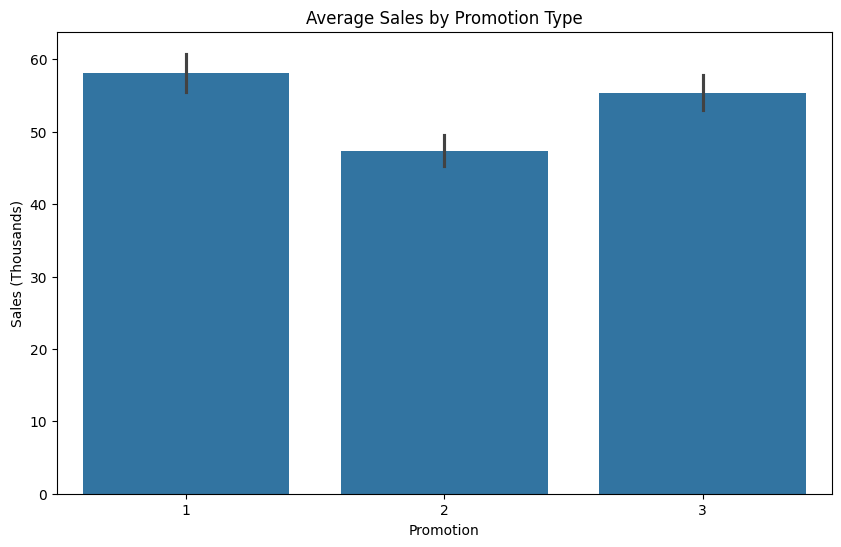

In [ ]:
# Visualize average sales by promotion
plt.figure(figsize=(10, 6))
sns.barplot(x='Promotion', y='SalesInThousands', data=data)
plt.title('Average Sales by Promotion Type')
plt.xlabel('Promotion')
plt.ylabel('Sales (Thousands)')
plt.show()

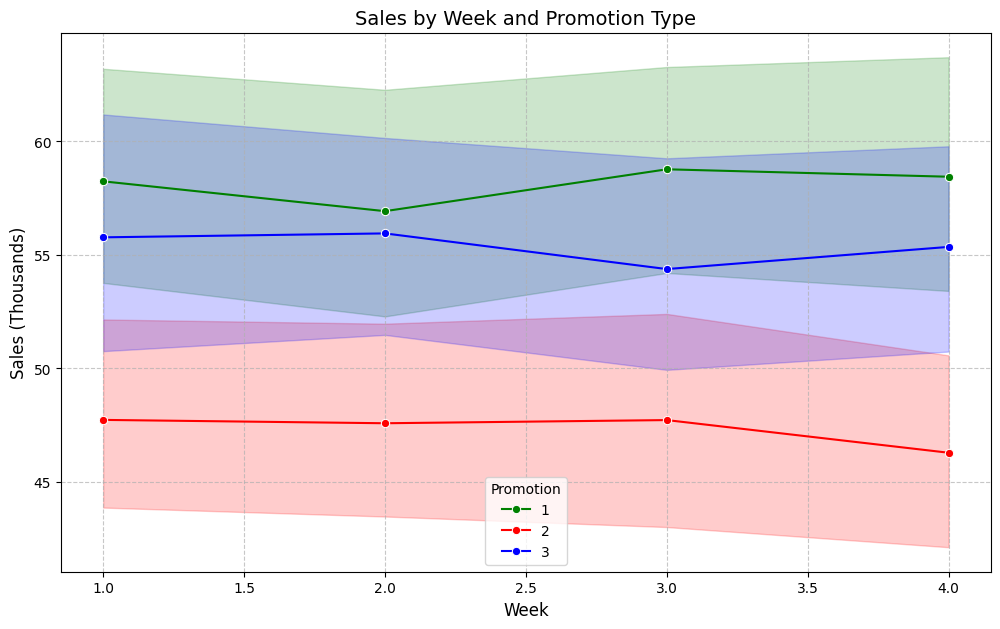


Examining potential confounding factors...


In [ ]:
# Time series analysis: Sales by week for each promotion
plt.figure(figsize=(12, 7))
sns.lineplot(x='week', y='SalesInThousands', hue='Promotion', data=data,
             marker='o', palette=['green', 'red', 'blue'],
             hue_order=[1, 2, 3])
plt.title('Sales by Week and Promotion Type', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Sales (Thousands)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Promotion')
plt.show()

# Analyze the impact of other variables
print("\nExamining potential confounding factors...")

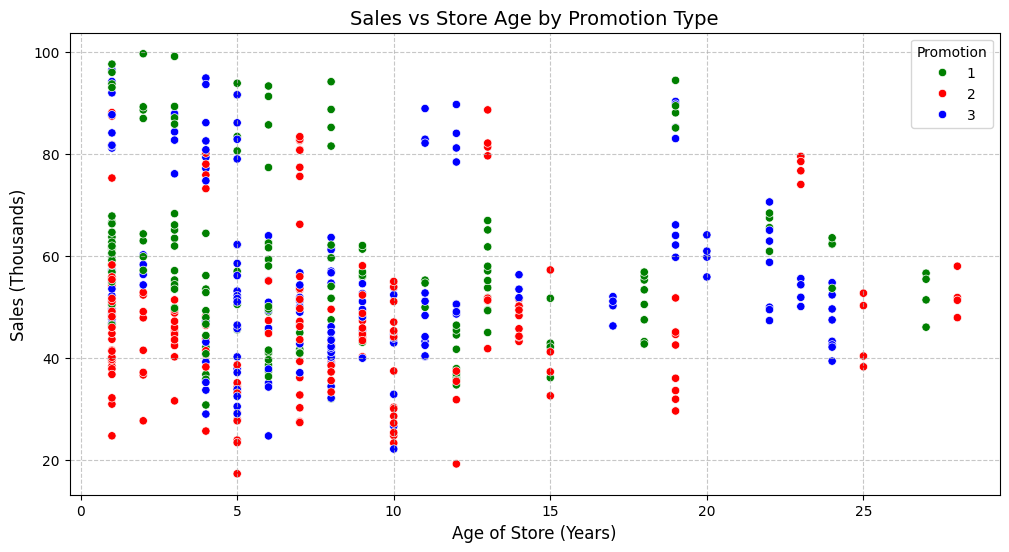

In [ ]:
# Create a joint plot to visualize relationship between AgeOfStore and Sales
plt.figure(figsize=(12, 6))
sns.scatterplot(x='AgeOfStore', y='SalesInThousands', hue='Promotion',
                data=data, palette=['green', 'red', 'blue'],
                hue_order=[1, 2, 3])
plt.title('Sales vs Store Age by Promotion Type', fontsize=14)
plt.xlabel('Age of Store (Years)', fontsize=12)
plt.ylabel('Sales (Thousands)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

It actually seems that older stores have lower sales on average compared to younger stores. Promotion one seems to do better with stores under 5 years old whereas promotion 2 does best with stores 10-15 or 20 - 25 years old. promotion 3 does not do well after 25 years old.

In [ ]:
# Check distribution of market sizes by promotion to detect potential biases
market_promo_cross = pd.crosstab(data['MarketSize'], data['Promotion'])
print("\nMarket Size distribution by Promotion:")
print(market_promo_cross)



Market Size distribution by Promotion:
Promotion    1    2    3
MarketSize              
Large       56   64   48
Medium      96  108  116
Small       20   16   24


<Figure size 1200x600 with 0 Axes>

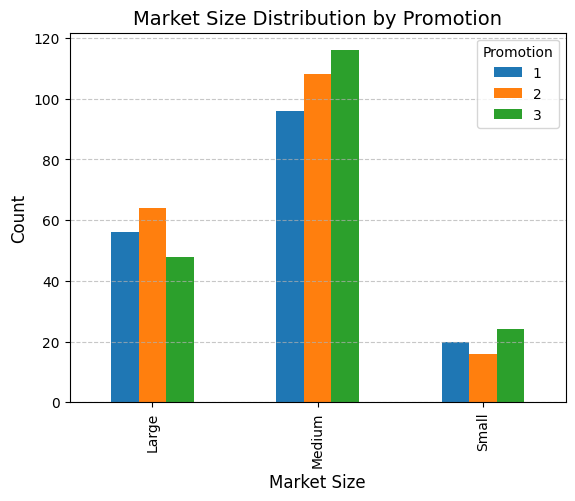

In [ ]:
# Visualize market size distribution by promotion
plt.figure(figsize=(12, 6))
market_promo_cross.plot(kind='bar', stacked=False)
plt.title('Market Size Distribution by Promotion', fontsize=14)
plt.xlabel('Market Size', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Promotion')
plt.show()


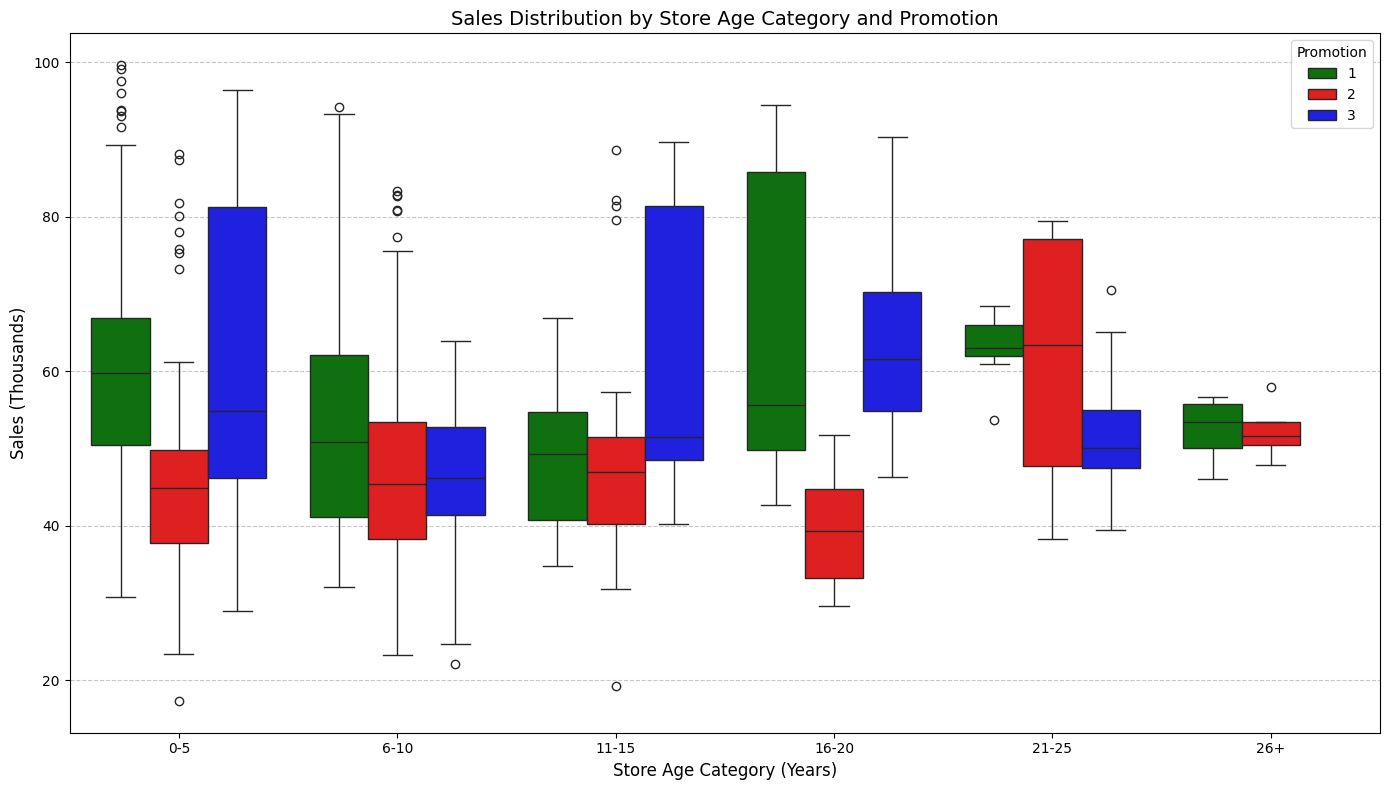

In [ ]:
# Define age category ranges and labels
bins = [0, 5, 10, 15, 20, 25, float('inf')]  # Define age ranges
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26+']  # Define labels for categories

# Create the 'AgeCategory' column using pd.cut
data['AgeCategory'] = pd.cut(data['AgeOfStore'], bins=bins, labels=labels)

# Create a categorical age plot to better visualize the interaction of age and promotion
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=data,
    x='AgeCategory',
    y='SalesInThousands',
    hue='Promotion',
    palette=['green', 'red', 'blue'],
    hue_order=[1, 2, 3]
)
plt.title('Sales Distribution by Store Age Category and Promotion', fontsize=14)
plt.xlabel('Store Age Category (Years)', fontsize=12)
plt.ylabel('Sales (Thousands)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Promotion')
plt.tight_layout()
plt.show()


Younger stores (0-5 years) under promotion 3 (blue) show higher sales and more variability. Promotion 2 (Red) often has lower medians across most store age categories , seems less effective in boosting sales. Older stores (26+ years) have less variation in sales across promotions, promotions dont seem to cause much difference anymore. Promotion 1 (Green) sometimes performs similarly to promotion 3 in younger stores but generally promotion 3 seems strongest overall for boosting sales.

In [ ]:
# Calculate average sales by age category and promotion
age_promo_sales = data.groupby(['AgeCategory', 'Promotion'])['SalesInThousands'].mean().reset_index()
age_promo_sales_pivot = age_promo_sales.pivot(index='AgeCategory', columns='Promotion', values='SalesInThousands')
print("\nAverage Sales by Age Category and Promotion:")
print(age_promo_sales_pivot)



Average Sales by Age Category and Promotion:
Promotion            1          2          3
AgeCategory                                 
0-5          62.887639  45.772875  60.200882
6-10         55.732500  47.246563  46.546500
11-15        48.007188  49.887917  60.150000
16-20        63.560833  39.421250  65.056250
21-25        63.045000  61.312500  51.878500
26+          52.392500  52.285000        NaN


<ipython-input-15-9318ca28120d>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_promo_sales = data.groupby(['AgeCategory', 'Promotion'])['SalesInThousands'].mean().reset_index()


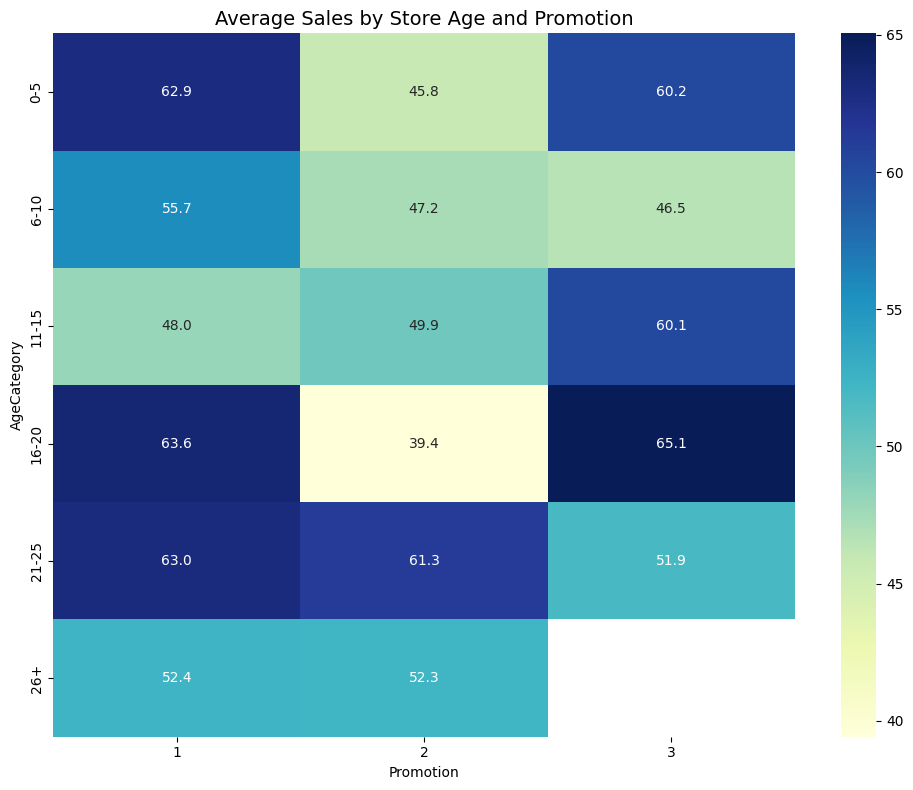

In [ ]:
# Heat map visualization of promotion performance by age category
plt.figure(figsize=(10, 8))
sns.heatmap(age_promo_sales_pivot, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Average Sales by Store Age and Promotion', fontsize=14)
plt.tight_layout()
plt.show()


Younger stores: Promotion 1 is probably the best bet. Middle - aged stores (11-20 years). Promotion 3 shines. Older stores (21+) Promotion 1 and sometimes 2 regains strength.

In [ ]:
# Calculate average sales by market size and promotion
market_promo_sales = data.groupby(['MarketSize', 'Promotion'])['SalesInThousands'].mean().reset_index()
market_promo_sales_pivot = market_promo_sales.pivot(index='MarketSize', columns='Promotion', values='SalesInThousands')
print("\nAverage Sales by Market Size and Promotion:")
print(market_promo_sales_pivot)


Average Sales by Market Size and Promotion:
Promotion           1          2          3
MarketSize                                 
Large       75.235893  60.322031  77.203958
Medium      47.672604  39.114352  45.468879
Small       60.162500  50.810625  59.514167


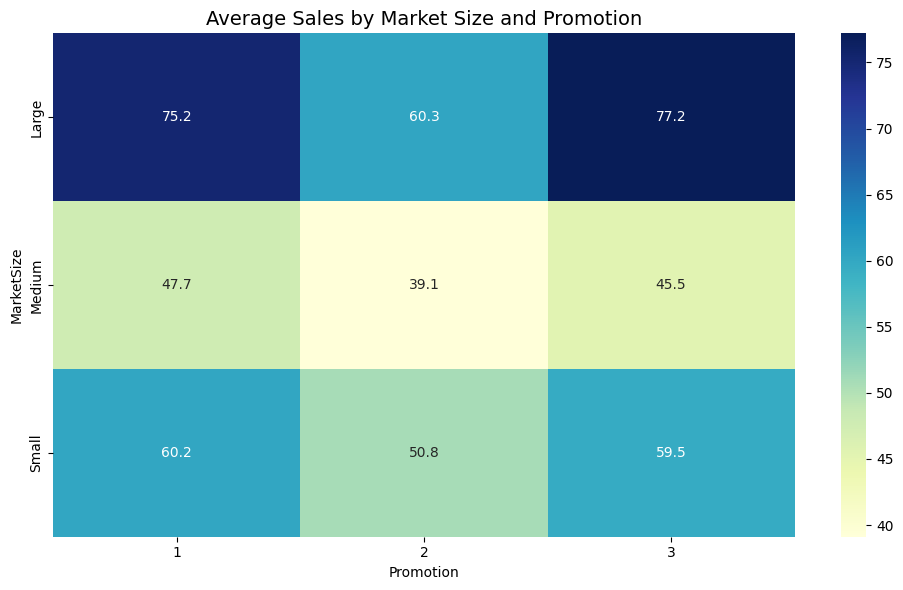

In [ ]:
# Heat map visualization of promotion performance by market size
plt.figure(figsize=(10, 6))
sns.heatmap(market_promo_sales_pivot, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Average Sales by Market Size and Promotion', fontsize=14)
plt.tight_layout()
plt.show()


Large Markets seem to do better with Promotion 1 or 3. Promotion 2 seems to consistently under perform when taking market size into account. Medium markets might need a new promotional strategy. Existing promotions are less effective.

In [ ]:
# Statistical Analysis with interactions

# Create dummy variables for categorical variables
data['Promo_1'] = (data['Promotion'] == 1).astype(int)
data['Promo_2'] = (data['Promotion'] == 2).astype(int)
data['Promo_3'] = (data['Promotion'] == 3).astype(int)

# Create market size dummies
data['Market_Small'] = (data['MarketSize'] == 'Small').astype(int)
data['Market_Medium'] = (data['MarketSize'] == 'Medium').astype(int)
data['Market_Large'] = (data['MarketSize'] == 'Large').astype(int)

# Create age category dummies
for age_cat in data['AgeCategory'].unique():
    data[f'Age_{age_cat}'] = (data['AgeCategory'] == age_cat).astype(int)


In [ ]:
# Create interaction terms for analysis
# Promotion-Age interactions
for promo in [1, 2, 3]:
    for age_cat in data['AgeCategory'].unique():
        data[f'Promo_{promo}_Age_{age_cat}'] = data[f'Promo_{promo}'] * data[f'Age_{age_cat}']

# Promotion-Market interactions
for promo in [1, 2, 3]:
    for market in ['Small', 'Medium', 'Large']:
        data[f'Promo_{promo}_Market_{market}'] = data[f'Promo_{promo}'] * data[f'Market_{market}']

Helps us to determine if the effectiveness of the promotion depend on market size or age or both.

In [ ]:
# Model 1: Simple model with just promotions (using Promotion 1 as reference)
model1 = sm.OLS.from_formula('SalesInThousands ~ Promo_2 + Promo_3', data=data).fit()
print("\nModel 1 - Simple comparison of promotions:")
print(model1.summary().tables[1])



Model 1 - Simple comparison of promotions:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.0990      1.231     47.186      0.000      55.680      60.518
Promo_2      -10.7696      1.704     -6.321      0.000     -14.116      -7.423
Promo_3       -2.7345      1.704     -1.605      0.109      -6.081       0.612


Promotion 1 had the highest average sales, promotion 2 led to significantly lower sales than promotion 1, promotion 3 had slightly lower sales than promotion 1.

In [ ]:
# Model 2: Control for market size and store age
model2 = sm.OLS.from_formula('SalesInThousands ~ Promo_2 + Promo_3 + Market_Medium + Market_Large + AgeOfStore', data=data).fit()
print("\nModel 2 - Controlling for market size and store age:")
print(model2.summary().tables[1])


Model 2 - Controlling for market size and store age:
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        59.9407      1.729     34.671      0.000      56.545      63.337
Promo_2         -10.7521      1.149     -9.355      0.000     -13.010      -8.494
Promo_3          -1.0739      1.152     -0.932      0.352      -3.337       1.189
Market_Medium   -12.5600      1.539     -8.161      0.000     -15.583      -9.537
Market_Large     14.0727      1.661      8.472      0.000      10.810      17.336
AgeOfStore        0.0709      0.071      0.995      0.320      -0.069       0.211


In [ ]:
# Compose the output file path for full summary
summary_txt_path = os.path.join(output_dir, 'model2_full_summary.txt')

# Write full summary to a text file
with open(summary_txt_path, 'w') as f:
    f.write(model2.summary().as_text())

print(f"Full Model 2 summary saved to {summary_txt_path}")

Full Model 2 summary saved to /content/drive/My Drive/Colab Notebooks/Outputs/model2_full_summary.txt


Controlling for market size and store age Promotion 1 is still performing the best.

In [ ]:
# Model 3: Add week effects
# Create interaction terms for weeks & promotion
for week in range(1, 5):
    data[f'Week_{week}'] = (data['week'] == week).astype(int)
    for promo in range(1, 4):
        data[f'Promo_{promo}_Week_{week}'] = data[f'Promo_{promo}'] * data[f'Week_{week}']

model3 = sm.OLS.from_formula('SalesInThousands ~ Promo_2 + Promo_3 + Market_Medium + Market_Large + AgeOfStore + Week_2 + Week_3 + Week_4', data=data).fit()
print("\nModel 3 - Adding week effects:")
print(model3.summary().tables[1])


Model 3 - Adding week effects:
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        60.2650      1.912     31.518      0.000      56.509      64.021
Promo_2         -10.7521      1.152     -9.331      0.000     -13.016      -8.489
Promo_3          -1.0739      1.155     -0.930      0.353      -3.343       1.195
Market_Medium   -12.5600      1.543     -8.140      0.000     -15.591      -9.529
Market_Large     14.0727      1.665      8.450      0.000      10.801      17.344
AgeOfStore        0.0709      0.071      0.992      0.321      -0.069       0.211
Week_2           -0.4040      1.318     -0.306      0.759      -2.994       2.186
Week_3           -0.3160      1.318     -0.240      0.811      -2.906       2.274
Week_4           -0.5775      1.318     -0.438      0.662      -3.167       2.012


After controlling for week effects, Promotion 1 is still the best choice—it delivers the highest sales. Promotion 2 should be avoided, and Promotion 3 is neither better nor significantly worse than Promotion 1.

In [ ]:
summary_txt_path = os.path.join(output_dir, 'model3_full_summary.txt')
with open(summary_txt_path, 'w') as f:
    f.write(model3.summary().as_text())

print(f"Full Model 2 summary saved to {summary_txt_path}")

Full Model 2 summary saved to /content/drive/My Drive/Colab Notebooks/Outputs/model3_full_summary.txt


In [ ]:
# Prepare features for ML modeling
features = ['MarketSize', 'AgeOfStore', 'Promotion']
target = 'SalesInThousands'

In [ ]:
# One-hot encode MarketSize and Promotion
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat = encoder.fit_transform(data[['MarketSize', 'Promotion']])
encoded_cols = encoder.get_feature_names_out(['MarketSize', 'Promotion'])
X = np.concatenate([X_cat, data[['AgeOfStore']].values], axis=1)
y = data[target].values

In [ ]:
# Fit Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)


RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
# Create a dataset for "simulated promotions" (counterfactuals)
# Holding MarketSize, AgeOfStore, LocationID fixed, vary Promotion across 1/2/3 for each row
sim_rows = []
for idx, row in data.iterrows():
    for promo in [1, 2, 3]:
        sim_rows.append({
            'MarketSize': row['MarketSize'],
            'AgeOfStore': row['AgeOfStore'],
            'Promotion': promo,
            'LocationID': row['LocationID'],
            'week': row['week'],
            'original_promo': row['Promotion'],
            'original_sales': row['SalesInThousands']
        })
sim_data = pd.DataFrame(sim_rows)

In [ ]:
# Encode features for the simulated dataset
sim_X_cat = encoder.transform(sim_data[['MarketSize', 'Promotion']])
sim_X = np.concatenate([sim_X_cat, sim_data[['AgeOfStore']].values], axis=1)
sim_data['PredictedSales'] = rf.predict(sim_X)


In [ ]:
# Average prediction for each promotion overall
overall_avg = sim_data.groupby('Promotion')['PredictedSales'].mean().reset_index()
print("Average predicted sales (thousands) for each promotion (overall):")
print(overall_avg)


Average predicted sales (thousands) for each promotion (overall):
   Promotion  PredictedSales
0          1       57.628379
1          2       46.618673
2          3       56.563377


In [ ]:
# Average prediction per promotion by MarketSize
market_avg = sim_data.groupby(['Promotion','MarketSize'])['PredictedSales'].mean().reset_index()
print("\nAverage predicted sales for each promotion by market size:")
print(market_avg.pivot(index='MarketSize', columns='Promotion', values='PredictedSales'))



Average predicted sales for each promotion by market size:
Promotion           1          2          3
MarketSize                                 
Large       74.428640  62.419690  75.220210
Medium      48.492479  37.476718  46.207064
Small       59.312444  51.132925  59.557910


In [ ]:
# Age bands
sim_data['AgeBand'] = pd.cut(sim_data['AgeOfStore'], bins=[0,5,10,20,100], labels=['0-5','6-10','11-20','21+'])
age_avg = sim_data.groupby(['Promotion','AgeBand'])['PredictedSales'].mean().reset_index()
print("\nAverage predicted sales for each promotion by age band:")
print(age_avg.pivot(index='AgeBand', columns='Promotion', values='PredictedSales'))


Average predicted sales for each promotion by age band:
Promotion          1          2          3
AgeBand                                   
0-5        60.687955  49.358876  59.398921
6-10       53.573709  43.200471  52.073924
11-20      58.135850  43.990175  58.144617
21+        56.474086  52.898657  55.358478


<ipython-input-34-e9ebcdbde03b>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_avg = sim_data.groupby(['Promotion','AgeBand'])['PredictedSales'].mean().reset_index()


In [ ]:
# Identify best promo per group
def best_promo(row):
    promo_sales = [row.get(1, 0), row.get(2, 0), row.get(3, 0)]
    return np.argmax(promo_sales) + 1

In [ ]:
# Best promotion by market size
best_by_market = market_avg.pivot(index='MarketSize', columns='Promotion', values='PredictedSales').apply(lambda r: np.argmax(r.values) + 1, axis=1)
print("\nBest promotion by market size:")
print(best_by_market)


Best promotion by market size:
MarketSize
Large     3
Medium    1
Small     3
dtype: int64


In [ ]:
# Best promotion by age band
best_by_age = age_avg.pivot(index='AgeBand', columns='Promotion', values='PredictedSales').apply(lambda r: np.argmax(r.values) + 1, axis=1)
print("\nBest promotion by age band:")
print(best_by_age)


Best promotion by age band:
AgeBand
0-5      1
6-10     1
11-20    3
21+      1
dtype: int64


In [ ]:
# Overall best
best_overall_promotion = int(overall_avg.loc[overall_avg['PredictedSales'].idxmax()]['Promotion'])
print(f"\nOverall, Promotion {best_overall_promotion} is predicted to deliver the highest sales.")


Overall, Promotion 1 is predicted to deliver the highest sales.


Applying Uplifting to find the best promotion based on each factors influence



In [ ]:
# 1. META-LEARNER APPROACH (S-LEARNER)
print("\n1. META-LEARNER (S-LEARNER) APPROACH")
print("   This approach uses a single model with promotion as a feature")

# Create features for the meta-learner model
# We'll include week as a feature here
X_meta = pd.DataFrame({
    'AgeOfStore': data['AgeOfStore'],
    'Week': data['week'],
    'MarketSize_Medium': data['Market_Medium'],
    'MarketSize_Large': data['Market_Large'],
    'Promotion': data['Promotion']
})
y_meta = data['SalesInThousands']

# Train a single Random Forest model
meta_model = RandomForestRegressor(n_estimators=200, random_state=42)
meta_model.fit(X_meta, y_meta)

# Create a grid of all combinations for prediction
unique_ages = sorted(data['AgeOfStore'].unique())
market_sizes = ['Small', 'Medium', 'Large']
promotions = [1, 2, 3]
weeks = [1, 2, 3, 4]

grid_rows = []
for age in unique_ages:
    for market in market_sizes:
        medium = 1 if market == 'Medium' else 0
        large = 1 if market == 'Large' else 0
        for week in weeks:
            for promo in promotions:
                grid_rows.append({
                    'AgeOfStore': age,
                    'Week': week,
                    'MarketSize_Medium': medium,
                    'MarketSize_Large': large,
                    'Promotion': promo,
                    'MarketSize': market,
                    'AgeBand': pd.cut([age], bins=[0,5,10,20,100], labels=['0-5','6-10','11-20','21+'])[0]
                })

grid_df = pd.DataFrame(grid_rows)
grid_df['PredictedSales'] = meta_model.predict(grid_df[['AgeOfStore', 'Week', 'MarketSize_Medium',
                                                      'MarketSize_Large', 'Promotion']])

# Calculate average predicted sales by promotion, market size and age band
s_learner_market = grid_df.groupby(['MarketSize', 'Promotion'])['PredictedSales'].mean().reset_index()
s_learner_age = grid_df.groupby(['AgeBand', 'Promotion'])['PredictedSales'].mean().reset_index()
s_learner_overall = grid_df.groupby(['Promotion'])['PredictedSales'].mean().reset_index()

print("\nS-Learner: Average predicted sales by promotion and market size:")
print(s_learner_market.pivot(index='MarketSize', columns='Promotion', values='PredictedSales'))

print("\nS-Learner: Average predicted sales by promotion and age band:")
print(s_learner_age.pivot(index='AgeBand', columns='Promotion', values='PredictedSales'))



1. META-LEARNER (S-LEARNER) APPROACH
   This approach uses a single model with promotion as a feature

S-Learner: Average predicted sales by promotion and market size:
Promotion           1          2          3
MarketSize                                 
Large       76.686500  65.076141  75.295740
Medium      49.535568  39.811201  47.465636
Small       59.893935  58.042018  59.910684

S-Learner: Average predicted sales by promotion and age band:
Promotion          1          2          3
AgeBand                                   
0-5        61.908000  53.020012  60.110970
11-20      65.481616  55.145820  63.928640
21+        58.469882  59.313939  62.829703
6-10       60.254572  48.089719  53.875269


Interestingly 21+ for Promotion 2 is supposedly outperforming promotion 1.

In [ ]:
# Identify the best promotion for each segment using S-Learner
s_best_by_market = s_learner_market.pivot(index='MarketSize', columns='Promotion',
                                         values='PredictedSales').idxmax(axis=1)
s_best_by_age = s_learner_age.pivot(index='AgeBand', columns='Promotion',
                                   values='PredictedSales').idxmax(axis=1)
s_best_overall = s_learner_overall.loc[s_learner_overall['PredictedSales'].idxmax()]['Promotion']

print("\nS-Learner: Best promotion by market size:")
print(s_best_by_market)

print("\nS-Learner: Best promotion by age band:")
print(s_best_by_age)

print(f"\nS-Learner: Overall best promotion: {int(s_best_overall)}")



S-Learner: Best promotion by market size:
MarketSize
Large     1
Medium    1
Small     3
dtype: int64

S-Learner: Best promotion by age band:
AgeBand
0-5      1
11-20    1
21+      3
6-10     1
dtype: int64

S-Learner: Overall best promotion: 1


Same overall results as before however.

In [ ]:
# 2. T-LEARNER APPROACH (SEPARATE MODELS)
print("\n\n2. T-LEARNER APPROACH")
print("   This approach builds separate models for each promotion")

# Separate data by promotion
p1_data = data[data['Promotion'] == 1]
p2_data = data[data['Promotion'] == 2]
p3_data = data[data['Promotion'] == 3]

# Prepare features for each promotion
X_columns = ['AgeOfStore', 'Week', 'MarketSize_Medium', 'MarketSize_Large']

# Train separate models
t_models = {}
for promo, promo_data in zip([1, 2, 3], [p1_data, p2_data, p3_data]):
    X_promo = promo_data[['AgeOfStore', 'week', 'Market_Medium', 'Market_Large']].copy()
    X_promo.columns = X_columns  # Rename 'week' to 'Week' for consistency
    y_promo = promo_data['SalesInThousands']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_promo, y_promo)
    t_models[promo] = model

# Prepare a grid for prediction (without Promotion column)
t_grid_df = grid_df.copy()

# Predict using each promotion-specific model
for promo in [1, 2, 3]:
    t_grid_df[f'Pred_Promo_{promo}'] = t_models[promo].predict(
        t_grid_df[['AgeOfStore', 'Week', 'MarketSize_Medium', 'MarketSize_Large']])

# Calculate average predicted values by segment
t_learner_market = t_grid_df.groupby('MarketSize')[['Pred_Promo_1', 'Pred_Promo_2', 'Pred_Promo_3']].mean()
t_learner_age = t_grid_df.groupby('AgeBand')[['Pred_Promo_1', 'Pred_Promo_2', 'Pred_Promo_3']].mean()
t_learner_overall = t_grid_df[['Pred_Promo_1', 'Pred_Promo_2', 'Pred_Promo_3']].mean()

print("\nT-Learner: Average predicted sales by promotion and market size:")
print(t_learner_market)

print("\nT-Learner: Average predicted sales by promotion and age band:")
print(t_learner_age)

print("\nT-Learner: Overall average predicted sales by promotion:")
print(t_learner_overall)

# Identify the best promotion for each segment using T-Learner
t_best_by_market = t_learner_market.idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
t_best_by_age = t_learner_age.idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
t_best_overall = t_learner_overall.idxmax().split('_')[-1]

print("\nT-Learner: Best promotion by market size:")
print(t_best_by_market)

print("\nT-Learner: Best promotion by age band:")
print(t_best_by_age)

print(f"\nT-Learner: Overall best promotion: {t_best_overall}")



2. T-LEARNER APPROACH
   This approach builds separate models for each promotion

T-Learner: Average predicted sales by promotion and market size:
            Pred_Promo_1  Pred_Promo_2  Pred_Promo_3
MarketSize                                          
Large          77.377364     63.273157     77.964066
Medium         49.477174     39.077760     47.479245
Small          61.330555     51.954135     61.630524

T-Learner: Average predicted sales by promotion and age band:
         Pred_Promo_1  Pred_Promo_2  Pred_Promo_3
AgeBand                                          
0-5         62.616187     52.178904     61.325581
11-20       66.072293     49.572829     63.965229
21+         59.443139     58.124118     65.893316
6-10        60.763741     46.016149     56.254754

T-Learner: Overall average predicted sales by promotion:
Pred_Promo_1    62.728365
Pred_Promo_2    51.435017
Pred_Promo_3    62.357945
dtype: float64

T-Learner: Best promotion by market size:
MarketSize
Large     3
Medium

Interestingly different recommendations for Market Size promotions. S Learner creates a **single model** (random forest) to predict sales and includes the promotion as a feature. It learns how promotions, market size, age and other factors jointly affect sales. T learner trains **seperate models ** (one per promo) each predicting sales as if all data was assigned to that specific promotion. For each segment it picks the best promo by comparing the three predicitons. S Learner tends to generalize more whereas t learner can identify "hidden gems" in promotion interactions better. Since our data is not sparse we dont risk overfitting.



3. UPLIFT VISUALIZATION
   Creating heatmaps to visualize promotion effectiveness by segment


<ipython-input-45-05f9e99a0237>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)


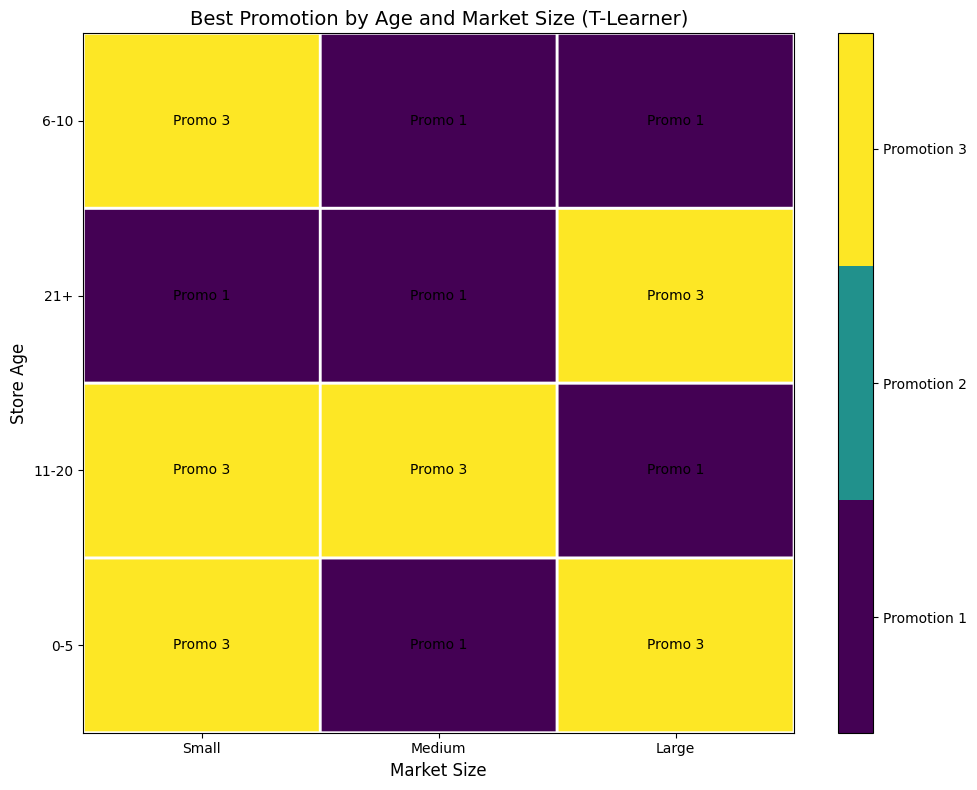

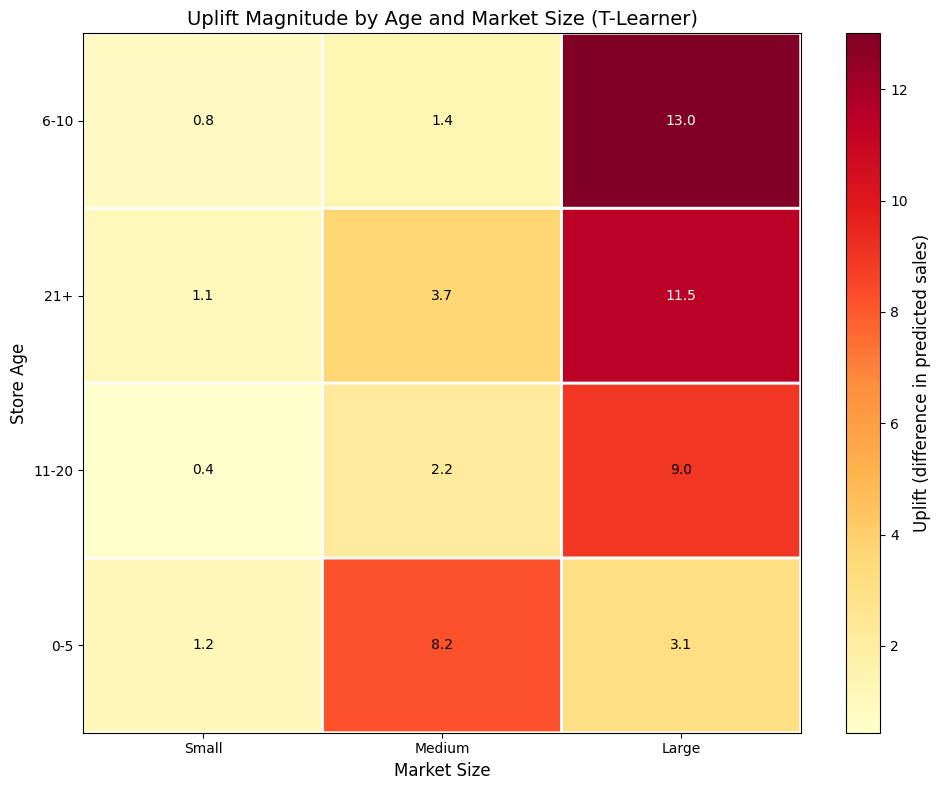

In [ ]:
# Uplift Visualization
print("\n\n3. UPLIFT VISUALIZATION")
print("   Creating heatmaps to visualize promotion effectiveness by segment")

# Create age-market grid for T-Learner
age_ranges = sorted(t_grid_df['AgeBand'].unique())
market_sizes = ['Small', 'Medium', 'Large']

# Reshape data for heatmap - T-Learner
best_promo_grid = np.zeros((len(age_ranges), len(market_sizes)))
uplift_grid = np.zeros((len(age_ranges), len(market_sizes)))

# Calculate average prediction for each age-market combination
for i, age in enumerate(age_ranges):
    for j, market in enumerate(market_sizes):
        segment_data = t_grid_df[(t_grid_df['AgeBand'] == age) & (t_grid_df['MarketSize'] == market)]
        avg_p1 = segment_data['Pred_Promo_1'].mean()
        avg_p2 = segment_data['Pred_Promo_2'].mean()
        avg_p3 = segment_data['Pred_Promo_3'].mean()

        # Find best promotion
        promo_avgs = {1: avg_p1, 2: avg_p2, 3: avg_p3}
        best_promo = max(promo_avgs, key=promo_avgs.get)
        best_promo_grid[i, j] = best_promo

        # Calculate max uplift (difference between best and second best)
        sorted_avgs = sorted(promo_avgs.values(), reverse=True)
        uplift_grid[i, j] = sorted_avgs[0] - sorted_avgs[1]

# Create heatmap for best promotion
plt.figure(figsize=(10, 8))
cmap = plt.cm.get_cmap('viridis', 3)
heatmap = plt.pcolor(best_promo_grid, cmap=cmap, edgecolors='w', linewidths=2)
cbar = plt.colorbar(heatmap)
cbar.set_ticks([1.33, 2, 2.67])
cbar.set_ticklabels(['Promotion 1', 'Promotion 2', 'Promotion 3'])

# Set labels
plt.title('Best Promotion by Age and Market Size (T-Learner)', fontsize=14)
plt.xticks(np.arange(len(market_sizes)) + 0.5, market_sizes)
plt.yticks(np.arange(len(age_ranges)) + 0.5, age_ranges)
plt.xlabel('Market Size', fontsize=12)
plt.ylabel('Store Age', fontsize=12)

# Add text annotations
for i in range(len(age_ranges)):
    for j in range(len(market_sizes)):
        plt.text(j + 0.5, i + 0.5, f'Promo {int(best_promo_grid[i, j])}',
                 ha='center', va='center',
                 color='white' if best_promo_grid[i, j] == 2 else 'black')

plt.tight_layout()
plt.show()

# Create heatmap for uplift magnitude
plt.figure(figsize=(10, 8))
heatmap = plt.pcolor(uplift_grid, cmap='YlOrRd', edgecolors='w', linewidths=2)
cbar = plt.colorbar(heatmap)
cbar.set_label('Uplift (difference in predicted sales)', fontsize=12)

# Set labels
plt.title('Uplift Magnitude by Age and Market Size (T-Learner)', fontsize=14)
plt.xticks(np.arange(len(market_sizes)) + 0.5, market_sizes)
plt.yticks(np.arange(len(age_ranges)) + 0.5, age_ranges)
plt.xlabel('Market Size', fontsize=12)
plt.ylabel('Store Age', fontsize=12)

# Add text annotations
for i in range(len(age_ranges)):
    for j in range(len(market_sizes)):
        plt.text(j + 0.5, i + 0.5, f'{uplift_grid[i, j]:.1f}',
                 ha='center', va='center',
                 color='black' if uplift_grid[i, j] < 10 else 'white')

plt.tight_layout()
plt.show()


Through the above heatmap with the T learner results, we could therefore target specific market sizes and stores to use certain promotions.



4. HETEROGENEOUS TREATMENT EFFECT ANALYSIS
   Analyzing how different store segments respond to promotions

Average Treatment Effects by Market Size:
              TE_2vs1   TE_3vs1    TE_3vs2
MarketSize                                
Large      -14.104207  0.586702  14.690909
Medium     -10.399415 -1.997929   8.401485
Small       -9.376421  0.299969   9.676390

Average Treatment Effects by Age Band:
           TE_2vs1   TE_3vs1    TE_3vs2
AgeBand                                
0-5     -10.437283 -1.290607   9.146676
11-20   -16.499465 -2.107065  14.392400
21+      -1.319021  6.450177   7.769198
6-10    -14.747592 -4.508987  10.238605


<Figure size 1200x600 with 0 Axes>

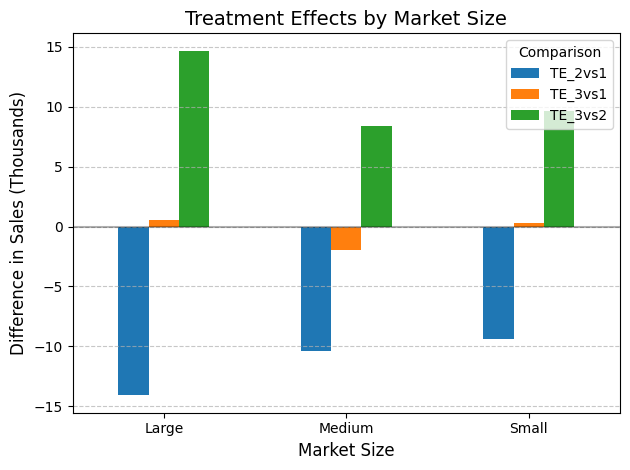

<Figure size 1200x600 with 0 Axes>

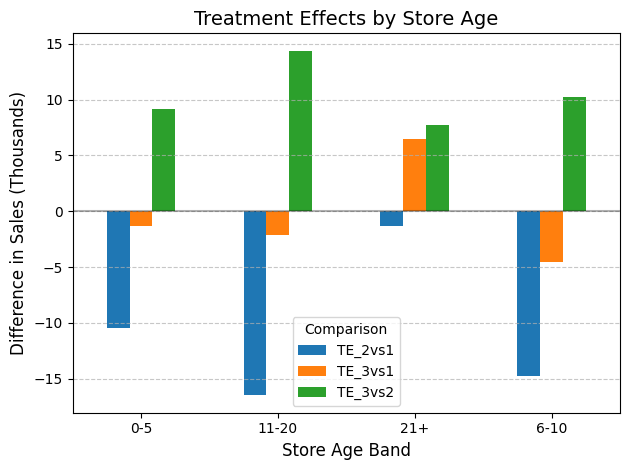

In [ ]:
# HETEROGENEOUS TREATMENT EFFECT ESTIMATION
print("\n\n4. HETEROGENEOUS TREATMENT EFFECT ANALYSIS")
print("   Analyzing how different store segments respond to promotions")

# Calculate treatment effects using T-Learner
t_grid_df['TE_2vs1'] = t_grid_df['Pred_Promo_2'] - t_grid_df['Pred_Promo_1']
t_grid_df['TE_3vs1'] = t_grid_df['Pred_Promo_3'] - t_grid_df['Pred_Promo_1']
t_grid_df['TE_3vs2'] = t_grid_df['Pred_Promo_3'] - t_grid_df['Pred_Promo_2']

# Analyze treatment effects by segment
te_by_market = t_grid_df.groupby('MarketSize')[['TE_2vs1', 'TE_3vs1', 'TE_3vs2']].mean()
te_by_age = t_grid_df.groupby('AgeBand')[['TE_2vs1', 'TE_3vs1', 'TE_3vs2']].mean()

print("\nAverage Treatment Effects by Market Size:")
print(te_by_market)

print("\nAverage Treatment Effects by Age Band:")
print(te_by_age)

# Visualize treatment effects
plt.figure(figsize=(12, 6))
te_by_market.plot(kind='bar')
plt.title('Treatment Effects by Market Size', fontsize=14)
plt.xlabel('Market Size', fontsize=12)
plt.ylabel('Difference in Sales (Thousands)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend(title='Comparison')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
te_by_age.plot(kind='bar')
plt.title('Treatment Effects by Store Age', fontsize=14)
plt.xlabel('Store Age Band', fontsize=12)
plt.ylabel('Difference in Sales (Thousands)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend(title='Comparison')
plt.tight_layout()
plt.show()

Chart 1: Promo 2 consistently performs much worse than promo 1 regardless of merket size. Promo 3 is as good or just a bit better than promo 1. Promo 3 much better than Promo 2 across the board.
Chart 2: Promo 2 is very detrimental especially for bands 11-20. Promo 3 outperforms Promo 1 more clearly, in younger stores the gap shrinks or reverses. Promo 3 is much better than Promo 2 everywhere. This highlights that through the T learner taking into account the segmentation effects it actually recommends Promo 3 over 1.

In [ ]:
# FINAL RECOMMENDATIONS
print("\n\n5. FINAL RECOMMENDATIONS")
print("   Synthesizing all findings to create actionable business recommendations")

# Create a summary table comparing results from different methods
summary = pd.DataFrame({
    'Segment': ['Overall', 'Small Market', 'Medium Market', 'Large Market',
               'Store Age 0-5', 'Store Age 6-10', 'Store Age 11-20', 'Store Age 21+'],
    'Raw Average': [best_overall_promotion,
                   best_by_market.get('Small', '-'),
                   best_by_market.get('Medium', '-'),
                   best_by_market.get('Large', '-'),
                   best_by_age.get('0-5', '-'),
                   best_by_age.get('6-10', '-'),
                   best_by_age.get('11-20', '-'),
                   best_by_age.get('21+', '-')],
    'S-Learner': [int(s_best_overall),
                 s_best_by_market.get('Small', '-'),
                 s_best_by_market.get('Medium', '-'),
                 s_best_by_market.get('Large', '-'),
                 s_best_by_age.get('0-5', '-'),
                 s_best_by_age.get('6-10', '-'),
                 s_best_by_age.get('11-20', '-'),
                 s_best_by_age.get('21+', '-')],
    'T-Learner': [int(t_best_overall),
                 t_best_by_market.get('Small', '-'),
                 t_best_by_market.get('Medium', '-'),
                 t_best_by_market.get('Large', '-'),
                 t_best_by_age.get('0-5', '-'),
                 t_best_by_age.get('6-10', '-'),
                 t_best_by_age.get('11-20', '-'),
                 t_best_by_age.get('21+', '-')],
})

print("\nRecommended Promotion by Segment and Method:")
print(summary)

# Get consensus recommendations
def get_consensus(row):
    recommendations = [row['Raw Average'], row['S-Learner'], row['T-Learner']]
    # Convert any string values to ints if possible
    numeric_recs = []
    for rec in recommendations:
        try:
            numeric_recs.append(int(rec))
        except:
            pass

    # If we have numeric recommendations, find the most common
    if numeric_recs:
        from collections import Counter
        count = Counter(numeric_recs)
        most_common = count.most_common(1)[0][0]
        return most_common
    else:
        return "No consensus"

summary['Consensus'] = summary.apply(get_consensus, axis=1)
print("\nConsensus Recommendations:")
print(summary[['Segment', 'Consensus']])



5. FINAL RECOMMENDATIONS
   Synthesizing all findings to create actionable business recommendations

Recommended Promotion by Segment and Method:
           Segment  Raw Average  S-Learner  T-Learner
0          Overall            1          1          1
1     Small Market            3          3          3
2    Medium Market            1          1          1
3     Large Market            3          1          3
4    Store Age 0-5            1          1          1
5   Store Age 6-10            1          1          1
6  Store Age 11-20            3          1          1
7    Store Age 21+            1          3          3

Consensus Recommendations:
           Segment  Consensus
0          Overall          1
1     Small Market          3
2    Medium Market          1
3     Large Market          3
4    Store Age 0-5          1
5   Store Age 6-10          1
6  Store Age 11-20          1
7    Store Age 21+          3


In [ ]:
# Final business recommendations
print("\nFINAL BUSINESS RECOMMENDATIONS:")
print("Based on our comprehensive uplift modeling analysis, we recommend the following:")

overall_rec = summary.loc[summary['Segment'] == 'Overall', 'Consensus'].values[0]
print(f"1. OVERALL RECOMMENDATION: Use Promotion {overall_rec} as the default strategy.")


FINAL BUSINESS RECOMMENDATIONS:
Based on our comprehensive uplift modeling analysis, we recommend the following:
1. OVERALL RECOMMENDATION: Use Promotion 1 as the default strategy.


In [ ]:
# Check if there are any deviations for specific segments
deviations = summary[summary['Consensus'] != overall_rec]
if not deviations.empty:
    print("\n2. SEGMENT-SPECIFIC RECOMMENDATIONS:")
    for _, row in deviations.iterrows():
        print(f"   • For {row['Segment']}, use Promotion {row['Consensus']} instead of the default.")



2. SEGMENT-SPECIFIC RECOMMENDATIONS:
   • For Small Market, use Promotion 3 instead of the default.
   • For Large Market, use Promotion 3 instead of the default.
   • For Store Age 21+, use Promotion 3 instead of the default.


In [ ]:
# Treatment effect insights
print("\n3. KEY INSIGHTS ON PROMOTION EFFECTS:")
# Find largest negative treatment effect
neg_te = te_by_market.min().min()
neg_te_comparison = te_by_market.min(axis=0).idxmin()
neg_te_segment = te_by_market[neg_te_comparison].idxmin()
print(f"   • Avoid using {neg_te_comparison.split('_')[1]} instead of {neg_te_comparison.split('vs')[1]} in {neg_te_segment} markets")
print(f"     (estimated sales decrease: {abs(neg_te):.2f} thousand)")

# Find largest positive treatment effect
pos_te = te_by_age.max().max()
pos_te_comparison = te_by_age.max(axis=0).idxmax()
pos_te_segment = te_by_age[pos_te_comparison].idxmax()
print(f"   • Particularly use {pos_te_comparison.split('_')[1]} instead of {pos_te_comparison.split('vs')[1]} for stores aged {pos_te_segment}")
print(f"     (estimated sales increase: {pos_te:.2f} thousand)")

print("\n4. IMPLEMENTATION STRATEGY:")
print("   • Implement the segment-specific recommendations where the uplift is substantial (>5 thousand)")
print("   • For segments with minimal uplift (<2 thousand), the default promotion is sufficient")
print("   • Monitor results closely and be prepared to adjust based on early performance data")

print("\n5. EXPECTED IMPACT:")
# Calculate expected impact if we use optimal promotions for each segment vs. using only the overall best
avg_sales_optimal = 0
avg_sales_default = 0
segment_weights = {
    'Small': 0.33,  # Approximated weights
    'Medium': 0.33,
    'Large': 0.34
}

for market, weight in segment_weights.items():
    market_best = summary.loc[summary['Segment'] == f'{market} Market', 'Consensus'].values[0]
    market_avg_best = grid_df[(grid_df['MarketSize'] == market) & (grid_df['Promotion'] == market_best)]['PredictedSales'].mean()
    market_avg_default = grid_df[(grid_df['MarketSize'] == market) & (grid_df['Promotion'] == overall_rec)]['PredictedSales'].mean()

    avg_sales_optimal += weight * market_avg_best
    avg_sales_default += weight * market_avg_default

expected_lift = avg_sales_optimal - avg_sales_default
expected_lift_pct = (expected_lift / avg_sales_default) * 100

print(f"   • Using segment-specific promotions can increase sales by approximately {expected_lift:.2f} thousand")
print(f"   • This represents a {expected_lift_pct:.1f}% improvement over using a single promotion strategy")



3. KEY INSIGHTS ON PROMOTION EFFECTS:
   • Avoid using 2vs1 instead of 1 in Large markets
     (estimated sales decrease: 14.10 thousand)
   • Particularly use 3vs2 instead of 2 for stores aged 11-20
     (estimated sales increase: 14.39 thousand)

4. IMPLEMENTATION STRATEGY:
   • Implement the segment-specific recommendations where the uplift is substantial (>5 thousand)
   • For segments with minimal uplift (<2 thousand), the default promotion is sufficient
   • Monitor results closely and be prepared to adjust based on early performance data

5. EXPECTED IMPACT:
   • Using segment-specific promotions can increase sales by approximately -0.47 thousand
   • This represents a -0.8% improvement over using a single promotion strategy


In this case sales would actually drop if we implement segment specific promotions (Promotion 3) and we are better of just using the default promotion of 1. This is a clear example of where uplift modelling actually performed worse than classical statistical analysis.